In [1]:
EMBEDDINGS_PATH = './output'
IMAGES_PATH = './input/img_align_celeba'
ID_FILE = '/home/sefidrodi/data/identity_CelebA.txt'

In [2]:
import os
import numpy as np
import csv
from sklearn.preprocessing import normalize
embeddings = np.load(os.path.join(EMBEDDINGS_PATH, 'embeddings.npy'))
embeddings = normalize(embeddings)
label_string = np.load(os.path.join(EMBEDDINGS_PATH,'label_strings.npy'))
labels = np.load(os.path.join(EMBEDDINGS_PATH, 'labels.npy'))
image_list = np.load(os.path.join(EMBEDDINGS_PATH, 'image_list.npy'))
img_2_ids = dict(list(csv.reader(open(ID_FILE, 'r'), delimiter=' ')))
ids_2_imgs = dict()
for img, identity in img_2_ids.items():
    if identity not in ids_2_imgs:
        ids_2_imgs[identity] = set()
    ids_2_imgs[identity].add(img)
ids_2_idx = dict()
idx_2_id = [None] * len(img_2_ids)
for ind, img in enumerate(image_list):
    id_ = img_2_ids[img.decode('utf-8')]
    idx_2_id[ind] = int(id_)
    if id_ not in ids_2_idx:
        ids_2_idx[id_] = set()
    ids_2_idx[id_].add(ind)        

In [3]:
import numpy as np
from sklearn.neighbors import KDTree
tree = KDTree(embeddings)

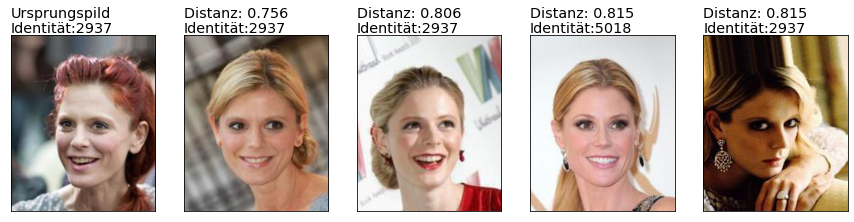

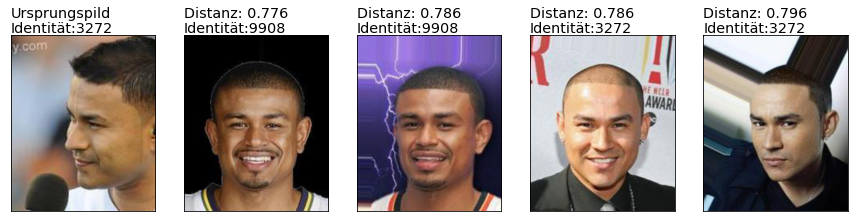

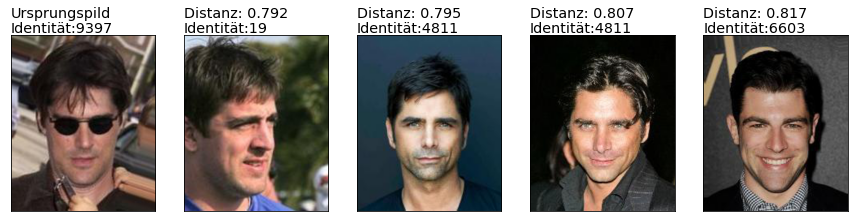

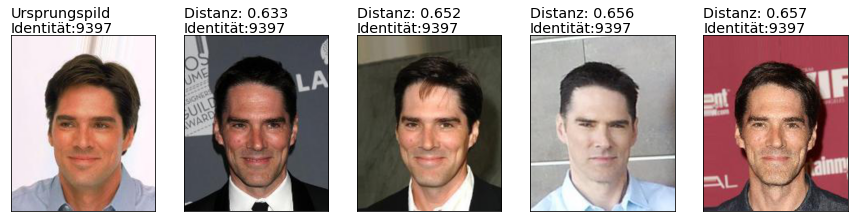

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

def img_reshape(image_path, width=300, height=300):
    img = Image.open(image_path).convert('RGB')
    wpercent = (width/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((width,hsize))
    img = np.asarray(img)
    return img

def nearest_neighbours_by_identity(identity, embeddings, idx_2_id, image_list, images_path, neighbours=3, exclude_identity=False):
    index = next(iter(ids_2_idx[str(identity)]))
    emb = embeddings[index]
    display_images = [os.path.join(images_path, image_list[index].decode("utf-8"))]
    dist, neighbour_indices = tree.query([emb], k=neighbours)
    for idx in neighbour_indices[0][1:]:
        if (exclude_identity and idx_2_id[idx] != identity) or not exclude_identity:
            display_images.append(os.path.join(images_path, image_list[idx].decode("utf-8")))
    return display_images, dist


def nearest_neighbours_by_file_name(file_name, embeddings, idx_2_id, image_list, images_path, neighbours=3, exclude_identity=False):
    index = list(image_list).index(file_name)
    emb = embeddings[int(index)]
    display_images = [os.path.join(images_path, file_name.decode("utf-8"))]
    dist, neighbour_indices = tree.query([emb], k=neighbours)
    for idx in neighbour_indices[0][1:]:
        if (exclude_identity and idx_2_id[idx] != identity) or not exclude_identity:
            display_images.append(os.path.join(images_path, image_list[idx].decode("utf-8")))
    return display_images, dist


def plot_images(images, img_2_ids, cols=5, distances=None):
    rows = int(len(images) / cols)
    img_count = 0
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,5))
    img_arr = []
    for image in images:
        img_arr.append(img_reshape(image))
    if (rows>1 and cols>1):
        for i in range(rows):
            for j in range(cols):
                if img_count < len(images):
                    axes[i, j].imshow(np.asarray(img_arr[img_count]))
                    if distances is not None:
                        content = 'distance: '+str(round(distances[0][img_count],3))+', identity:'+img_2_ids[os.path.split(images[img_count])[1]]
                        axes[i, j].text(-1,-5,content, size="x-large")
                    axes[i, j].set_axis_off()
                    img_count+=1
                    axes[i, j].get_xaxis().set_visible(False)
                    axes[i, j].get_yaxis().set_visible(False)
    else:
        for i in range(cols):
            if img_count < len(images):
                axes[i].imshow(np.asarray(img_arr[img_count]))
                if distances is not None:
                    if i!=0:
                        content = 'Distanz: '+str(round(distances[0][img_count],3))
                    else:
                        content = 'Ursprungspild'
                    axes[i].text(-1,-35,content, size="x-large")
                    content = 'Identität:'+img_2_ids[os.path.split(images[img_count])[1]]
                    axes[i].text(-1,-5,content, size="x-large")
                img_count+=1
                axes[i].get_xaxis().set_visible(False)
                axes[i].get_yaxis().set_visible(False)

nn, dist = nearest_neighbours_by_file_name(b'000002.jpg', embeddings, idx_2_id, image_list, IMAGES_PATH, neighbours=5, exclude_identity=False)
plot_images(nn, img_2_ids, distances=dist)


nn, dist = nearest_neighbours_by_file_name(b'000036.jpg', embeddings, idx_2_id, image_list, IMAGES_PATH, neighbours=5, exclude_identity=False)
plot_images(nn, img_2_ids, distances=dist)


nn, dist = nearest_neighbours_by_file_name(b'000053.jpg', embeddings, idx_2_id, image_list, IMAGES_PATH, neighbours=5, exclude_identity=False)
plot_images(nn, img_2_ids, distances=dist)

nn, dist = nearest_neighbours_by_identity(9397, embeddings, idx_2_id, image_list, IMAGES_PATH, neighbours=5, exclude_identity=False)
plot_images(nn, img_2_ids, distances=dist)

/home/sefidrodi/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sefidrodi/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 24 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 0.464953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.653053
[t-SNE] KL divergence after 1000 iterations: 0.465818


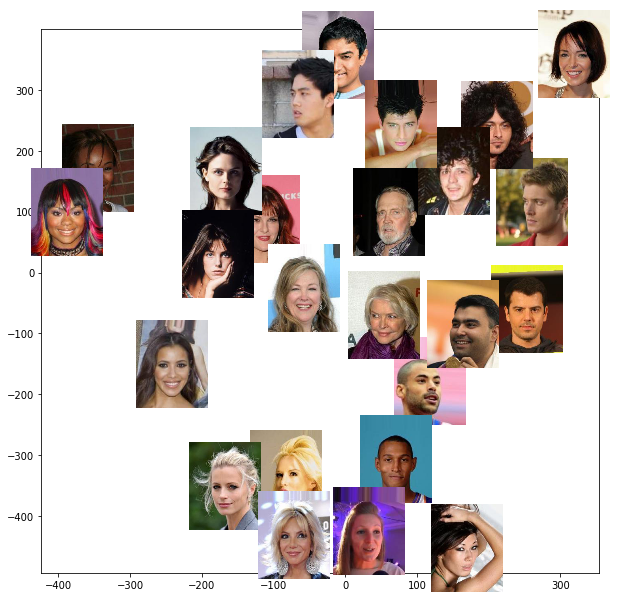

In [139]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

sample = embeddings[0:25]

tsne = TSNE(n_components=2, verbose=1, perplexity=10)
tsne_results = tsne.fit_transform(sample)



def getImage(path):
    return OffsetImage(plt.imread(os.path.join(IMAGES_PATH, path.decode("utf-8"))), zoom=0.4)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(tsne_results[:,0], tsne_results[:,1])

for i in range(0,len(sample)):
    ab = AnnotationBbox(getImage(image_list[i]), tuple(tsne_results[i]), frameon=False)
    ax.add_artist(ab)